In [1]:
import torch
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix # for evaluating results
from tqdm.notebook import tqdm # for progress bars
import torch.nn as nn # to load all neural net functionality
from torch.utils.data import DataLoader # lets us load data in batches
from torchvision import datasets, transforms

%matplotlib inline

In [2]:
import numpy as np

In [3]:
from tqdm.notebook import tqdm # for progress bars

In [4]:
print('Your torch version is {}'.format(torch.__version__))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

Your torch version is 2.1.0+cu118


device(type='cuda')

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image to mean=0.5 and std=0.5 for each channel
])

training_data = datasets.CIFAR10(root="data", train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root="data", train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
training_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [7]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [8]:
img, label = training_data[0]

In [9]:
print(img.shape)

torch.Size([3, 32, 32])


In [10]:
unnormalize = transforms.Compose([
    transforms.Normalize((-1, -1, -1), (2, 2, 2)),  # Inverse of the normalization
])

def show_image_3(image, lab):
  figure = plt.figure(figsize = (8,8))
  im= np.transpose(unnormalize(image).numpy(), (1, 2, 0))
  plt.title("Label %i "%(label))
  plt.axis("off")
  plt.imshow(im, cmap="gray")
  plt.show()

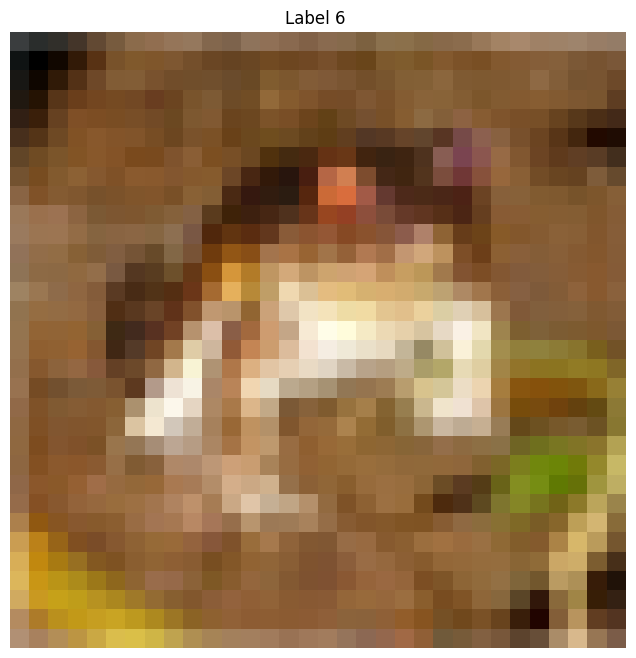

In [11]:
show_image_3(img, label)

## Use Dataloader

In [12]:
B = 128
E = 5


In [13]:
train_loader = DataLoader(training_data, batch_size=B, shuffle=True)
test_loader = DataLoader(test_data, batch_size=B, shuffle=False)

In [14]:
print(train_loader.dataset[0][1]) # label
print(train_loader.dataset[0][0].shape) #image.shape


6
torch.Size([3, 32, 32])


## CNN

Structure has to be:

- CONV(32F)
- RELU
- CONV(32)
- RElU
- MAXP(2)
- CONV(32F)
- RELU
- MAXP(2)
- DENSE

We want output to be of Dim 10

In [15]:
#image has shape 3*32*32 and 10 different possible classes



class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.network = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size = 3, stride = 1, padding = 1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 32, kernel_size = 3, stride = 1, padding = 1)  ,
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2) ,
            torch.nn.Conv2d(32, 32, kernel_size = 3, stride = 1, padding = 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2),
            torch.nn.Flatten(),
            torch.nn.Linear(8*8*32, 10))


    def forward(self, x): #forward pass
        return self.network(x)

In [16]:
model = CNN()

model

CNN(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=2048, out_features=10, bias=True)
  )
)

In [17]:
model.to(device)

CNN(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=2048, out_features=10, bias=True)
  )
)

In [18]:
from torchsummary import summary

summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 32, 32, 32]           9,248
              ReLU-4           [-1, 32, 32, 32]               0
         MaxPool2d-5           [-1, 32, 16, 16]               0
            Conv2d-6           [-1, 32, 16, 16]           9,248
              ReLU-7           [-1, 32, 16, 16]               0
         MaxPool2d-8             [-1, 32, 8, 8]               0
           Flatten-9                 [-1, 2048]               0
           Linear-10                   [-1, 10]          20,490
Total params: 39,882
Trainable params: 39,882
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.22
Params size (MB): 0.15
Estimated Tot

### Optimizers and criterions

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #in this example adam is used
criterion = nn.CrossEntropyLoss()

To show image: img.permute(1, 2, 0)

## Without Data Augmentation

In [20]:
def train(epoch, model, data_loader, log_interval = 200):
    #set model to training model
    model.train()
    total_train_loss = 0
    total_correct = 0

    #Loop over batch from training set
    for batch_idx, (data, target) in enumerate(tqdm(data_loader, desc=f"Training Epoch {epoch}")):
        #tqdm is used to get updates on which training epoch we are in
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)
        # Reset the gradient buffers to zero
        optimizer.zero_grad()

        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        # Updates the gradients buffer on each parameter
        loss.backward()

        # Update weights
        # Applies the calcualted gradients to each parameter
        # based on the selected optimizer and its configuration.
        # such as the learning rate.
        optimizer.step()

        total_train_loss += loss.item()

        # The maximum value of dimension 1 (class dimension)
        # is the predicted class. Only the class index is
        # relevant, hence the first return value is ignored.
        # as: values, indices = torch.max(output, dim=1)
        _, pred = torch.max(output, dim=1)

        # pred == target gives a boolean tensor, where each
        # element represents whether it was correctly predicted.
        # Taking the sum gives the number of correct predictions
        # for this particular batch.
        total_correct += torch.sum(pred == target).item()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.data.item()))

    accuracy_train = total_correct / len(data_loader.dataset)
    total_train_loss = total_train_loss / len(data_loader)

    return {
        "loss": total_train_loss,
        "accuracy": accuracy_train,
    }

In [21]:
@torch.inference_mode()
def validate(model, data_loader):
    # Put the model in eval mode, which disables
    # training specific behaviour, such as Dropout.
    model.eval()

    val_loss = 0
    total_correct = 0
    total_preds = []
    total_targets = []

    for data, target in tqdm(data_loader, desc="Validation"):
        data = data.to(device)
        target = target.to(device)

        output = model(data)
        val_loss += criterion(output, target).item()

        _, pred = torch.max(output, dim=1)
        total_correct += torch.sum(pred == target).item()
        # Keep the predictions and targets to inspect later on.
        # .detach() decouples it from the computational graph
        # and .cpu() ensures it's on the CPU, since it shouldn't
        # occupy any unnecesary GPU memory.
        total_preds.append(pred.detach().cpu())
        # target isn't tracked in the computational graph
        # (it's a leaf with requires_grad=False), adding the
        # .detach() doesn't do anything, but if in doubt, just add it.
        total_targets.append(target.cpu())

    val_loss /= len(data_loader)
    accuracy = total_correct / len(data_loader.dataset)

    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        val_loss, total_correct, len(data_loader.dataset), 100 * accuracy))

    return {
        "loss": val_loss,
        "accuracy": accuracy,
        "predictions": torch.cat(total_preds),
        "targets": torch.cat(total_targets),
    }

In [22]:
%%time

epochs = E

# Keep track of stats to plot them
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, epochs + 1):
    train_result = train(epoch, model, train_loader)
    train_losses.append(train_result["loss"])
    train_accuracies.append(train_result["accuracy"])

    val_result = validate(model, test_loader)
    val_losses.append(val_result["loss"])
    val_accuracies.append(val_result["accuracy"])

Training Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.300592
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.352235


Validation:   0%|          | 0/79 [00:00<?, ?it/s]


Validation set: Average loss: 1.2580, Accuracy: 5574/10000 (55.74%)



Training Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.291905
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.106089


Validation:   0%|          | 0/79 [00:00<?, ?it/s]


Validation set: Average loss: 1.0589, Accuracy: 6284/10000 (62.84%)



Training Epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.063323
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.855572


Validation:   0%|          | 0/79 [00:00<?, ?it/s]


Validation set: Average loss: 0.9707, Accuracy: 6597/10000 (65.97%)



Training Epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.895317
Train Epoch: 4 [25600/50000 (51%)]	Loss: 0.781123


Validation:   0%|          | 0/79 [00:00<?, ?it/s]


Validation set: Average loss: 0.9003, Accuracy: 6856/10000 (68.56%)



Training Epoch 5:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 5 [0/50000 (0%)]	Loss: 0.778707
Train Epoch: 5 [25600/50000 (51%)]	Loss: 0.529610


Validation:   0%|          | 0/79 [00:00<?, ?it/s]


Validation set: Average loss: 0.8717, Accuracy: 6977/10000 (69.77%)

CPU times: user 1min 41s, sys: 842 ms, total: 1min 42s
Wall time: 1min 45s


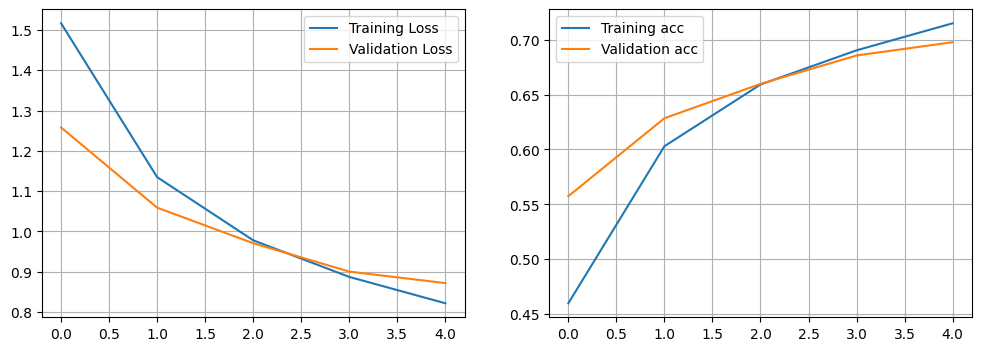

In [23]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.plot(train_losses, label = "Training Loss")
ax1.plot(val_losses, label = "Validation Loss")
ax1.legend()
ax1.grid()

ax2.plot(train_accuracies, label = "Training acc")
ax2.plot(val_accuracies, label = "Validation acc")
ax2.legend()
ax2.grid()

## With Data Augmentation

In [24]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [25]:
training_data_aug = datasets.CIFAR10(root="data", train=True, download=True, transform=train_transform)
test_data = datasets.CIFAR10(root="data", train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


## Show what possible image could look like

In [26]:
transform_unnorm = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.Normalize((-1, -1, -1), (2, 2, 2))
])

In [27]:
def show_image_transform(image, lab):
  figure = plt.figure(figsize = (8,8))
  im= np.transpose(transform_unnorm(image).numpy(), (1, 2, 0))
  plt.title("Label %i "%(label))
  plt.axis("off")
  plt.imshow(im, cmap="gray")
  plt.show()

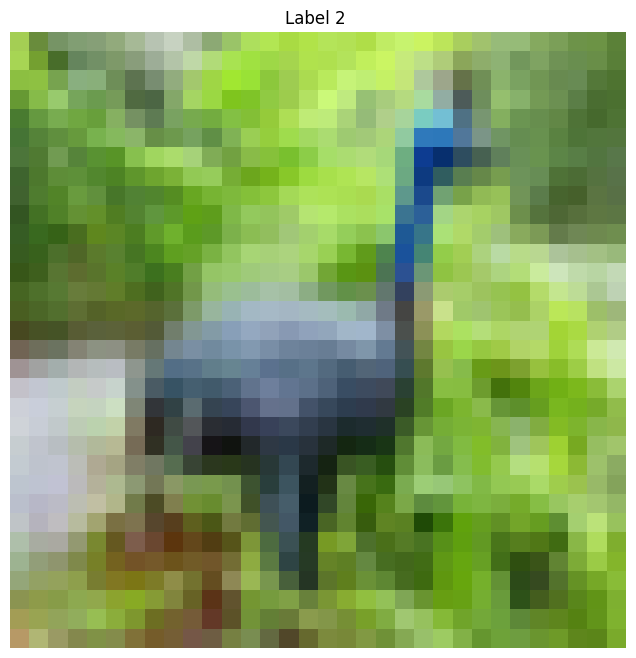

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


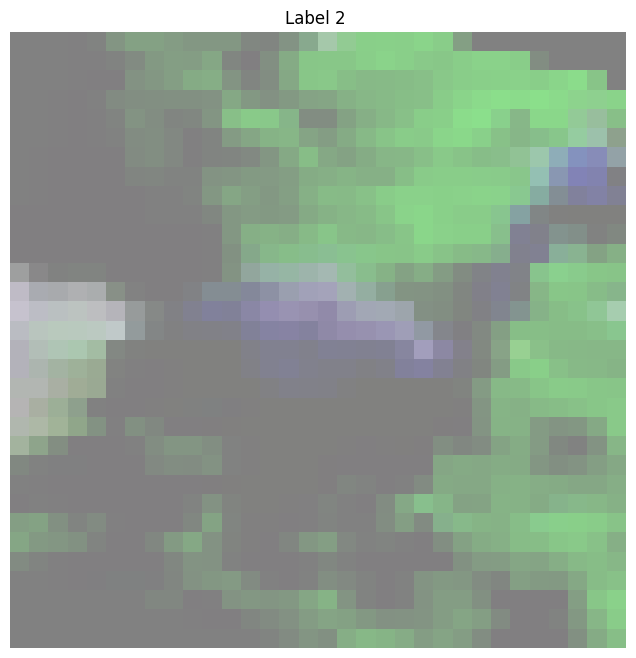

In [28]:
img, label = training_data[6]

show_image_3(img, label)
show_image_transform(img, label)

## Load and train model

In [29]:
model_aug = CNN()

model_aug.to(device)

CNN(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=2048, out_features=10, bias=True)
  )
)

In [30]:
optimizer = torch.optim.Adam(model_aug.parameters(), lr=0.001) #in this example adam is used
criterion = nn.CrossEntropyLoss()

In [31]:
train_loader = DataLoader(training_data_aug, batch_size=B, shuffle=True)
test_loader = DataLoader(test_data, batch_size=B, shuffle=False)

In [32]:
%%time

epochs = E

# Keep track of stats to plot them
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, epochs + 1):
    train_result = train(epoch, model_aug, train_loader)
    train_losses.append(train_result["loss"])
    train_accuracies.append(train_result["accuracy"])

    val_result = validate(model_aug, test_loader)
    val_losses.append(val_result["loss"])
    val_accuracies.append(val_result["accuracy"])

Training Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.301816
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.698812


Validation:   0%|          | 0/79 [00:00<?, ?it/s]


Validation set: Average loss: 1.5588, Accuracy: 4266/10000 (42.66%)



Training Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.813741
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.537780


Validation:   0%|          | 0/79 [00:00<?, ?it/s]


Validation set: Average loss: 1.4452, Accuracy: 4860/10000 (48.60%)



Training Epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.758113
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.593772


Validation:   0%|          | 0/79 [00:00<?, ?it/s]


Validation set: Average loss: 1.2775, Accuracy: 5465/10000 (54.65%)



Training Epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 4 [0/50000 (0%)]	Loss: 1.432959
Train Epoch: 4 [25600/50000 (51%)]	Loss: 1.422999


Validation:   0%|          | 0/79 [00:00<?, ?it/s]


Validation set: Average loss: 1.2823, Accuracy: 5456/10000 (54.56%)



Training Epoch 5:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 5 [0/50000 (0%)]	Loss: 1.304082
Train Epoch: 5 [25600/50000 (51%)]	Loss: 1.223907


Validation:   0%|          | 0/79 [00:00<?, ?it/s]


Validation set: Average loss: 1.2374, Accuracy: 5647/10000 (56.47%)

CPU times: user 5min 53s, sys: 1.97 s, total: 5min 55s
Wall time: 5min 59s


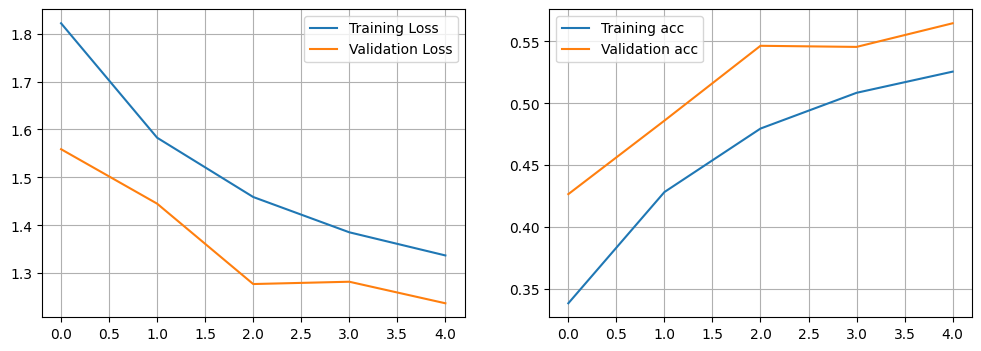

In [33]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.plot(train_losses, label = "Training Loss")
ax1.plot(val_losses, label = "Validation Loss")
ax1.legend()
ax1.grid()

ax2.plot(train_accuracies, label = "Training acc")
ax2.plot(val_accuracies, label = "Validation acc")
ax2.legend()
ax2.grid()

Can see here that the model does not perform as well as without data augmentation. The model appears to be performing better on the test data.

##Continue training model that we already trained without data augmentation

In [34]:
from torch.utils.data import ConcatDataset

train_data_combined = ConcatDataset([training_data, training_data_aug])

train_loader= DataLoader(train_data_combined, batch_size=B, shuffle=True)

In [35]:
model_comb = CNN()

model_comb.to(device)

optimizer = torch.optim.Adam(model_comb.parameters(), lr=0.001) #in this example adam is used
criterion = nn.CrossEntropyLoss()

In [36]:
epochs = E

# Keep track of stats to plot them
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, epochs + 1):
    train_result = train(epoch, model_comb, train_loader)
    train_losses.append(train_result["loss"])
    train_accuracies.append(train_result["accuracy"])

    val_result = validate(model_comb, test_loader)
    val_losses.append(val_result["loss"])
    val_accuracies.append(val_result["accuracy"])

Training Epoch 1:   0%|          | 0/782 [00:00<?, ?it/s]

Train Epoch: 1 [0/100000 (0%)]	Loss: 2.304784
Train Epoch: 1 [25600/100000 (26%)]	Loss: 1.665712
Train Epoch: 1 [51200/100000 (51%)]	Loss: 1.388219
Train Epoch: 1 [76800/100000 (77%)]	Loss: 1.597691


Validation:   0%|          | 0/79 [00:00<?, ?it/s]


Validation set: Average loss: 1.2030, Accuracy: 5774/10000 (57.74%)



Training Epoch 2:   0%|          | 0/782 [00:00<?, ?it/s]

Train Epoch: 2 [0/100000 (0%)]	Loss: 1.287862
Train Epoch: 2 [25600/100000 (26%)]	Loss: 1.421994
Train Epoch: 2 [51200/100000 (51%)]	Loss: 1.158962
Train Epoch: 2 [76800/100000 (77%)]	Loss: 1.302448


Validation:   0%|          | 0/79 [00:00<?, ?it/s]


Validation set: Average loss: 1.0284, Accuracy: 6483/10000 (64.83%)



Training Epoch 3:   0%|          | 0/782 [00:00<?, ?it/s]

Train Epoch: 3 [0/100000 (0%)]	Loss: 1.180399
Train Epoch: 3 [25600/100000 (26%)]	Loss: 1.319815
Train Epoch: 3 [51200/100000 (51%)]	Loss: 1.155214
Train Epoch: 3 [76800/100000 (77%)]	Loss: 1.070594


Validation:   0%|          | 0/79 [00:00<?, ?it/s]


Validation set: Average loss: 0.9323, Accuracy: 6765/10000 (67.65%)



Training Epoch 4:   0%|          | 0/782 [00:00<?, ?it/s]

Train Epoch: 4 [0/100000 (0%)]	Loss: 1.130839
Train Epoch: 4 [25600/100000 (26%)]	Loss: 1.326700
Train Epoch: 4 [51200/100000 (51%)]	Loss: 1.083920
Train Epoch: 4 [76800/100000 (77%)]	Loss: 1.098099


Validation:   0%|          | 0/79 [00:00<?, ?it/s]


Validation set: Average loss: 0.9165, Accuracy: 6817/10000 (68.17%)



Training Epoch 5:   0%|          | 0/782 [00:00<?, ?it/s]

Train Epoch: 5 [0/100000 (0%)]	Loss: 0.998013
Train Epoch: 5 [25600/100000 (26%)]	Loss: 1.050326
Train Epoch: 5 [51200/100000 (51%)]	Loss: 1.036144
Train Epoch: 5 [76800/100000 (77%)]	Loss: 1.070824


Validation:   0%|          | 0/79 [00:00<?, ?it/s]


Validation set: Average loss: 0.8894, Accuracy: 6947/10000 (69.47%)



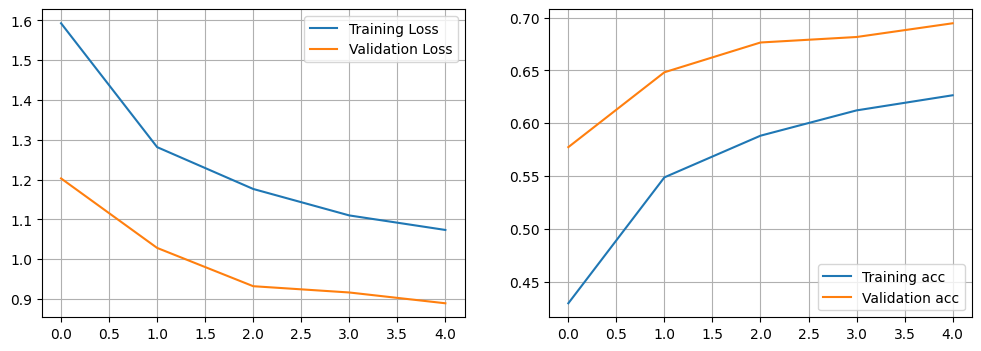

In [37]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.plot(train_losses, label = "Training Loss")
ax1.plot(val_losses, label = "Validation Loss")
ax1.legend()
ax1.grid()

ax2.plot(train_accuracies, label = "Training acc")
ax2.plot(val_accuracies, label = "Validation acc")
ax2.legend()
ax2.grid()

The idea here would be to make the model more robust using augmented data. However, it seems to fit the validation data better than the training data which seems odd.